# Agile semi-automatic image clustering (filtering) using pre-trained Convolutional Neural Networks and clustering algorithms
### Authors: Michał Woźniak (id: 385190), Michał Wrzesiński (id: 385197)
### Date: 14.11.2019

In [76]:
#setting width of jupyter notebook document to 80%
from IPython.core.display import display, HTML, Latex, Math
display(HTML("<style>.container { width:80% !important; }</style>"))

# 1. Introduction
## 1.1 Background
Currently, deep neural networks are used in many areas. One of them is the Computer Vision. More and more commercial companies are deciding to use these technologies to solve their daily problems and tasks. They usually decide to outsource a project to a data science consulting company. This consulting company is given limited time (always around 3-6 months) to prepare a code that will serve as a Proof of Concept or Most Valuable Product. Therefore, the race against time begins.
<br><br>
As everyone knows, know-how alone is not enough. The key is correct and reliable preparation of data for analysis and learning. Very often, customers specify their requirements and set business goals, but at the same time provide data in very poor quality. In the case of photos, it is usually a large number of images that are not useful in the analysis and should be discarded at the very beginning of the study. Clients usually do a snapshot of data from databases (there is no meaningful labeling) and do not care what they are providing to machine learning consultants. In this situation you have to manage somehow. By nature, it would not be optimal to filter photos manually. Usually, such work is outsourced to a low-skilled person to reduce the cost of their remuneration. However, it happens that regular scientists do such exercises during the project because of the scale of the problem and time, which is required to employ low-skilled worker. So far in practice, not developed a good methodology of fighting this problem. This article may be the solution.
## 1.2 Purpose of the study
In this paper authors would like to propose new approach to removing unneeded images from databases, which will later be used to train machine learning algorithms. Their goal was to develop a semi-automatic solution based on pre-trained convolutional neural networks and clustering algorithms that would be fast, precise and robust in image clustering. The word fast means the lack of carrying out the learning process. This assumption enables scientists to quickly prototype during a commercial project. Precision and robustness address the issue of algorithm resistance to various types and classes of images. The simplest solution would seem to be the use of pre-trained convolutional neural networks with the top soft-max layer. However, this network is only trained for approximately 1,000 classes on ImageNet dataset. Therefore, it is useful for a strictly defined number of cases (1000). In this paper researchers are proposing to turn off a top layer of the network and treat CNN as a tool dedicated to feature extraction from images. That's why the approach presented in this article is not limited to any number of classes. The only condition and assumption is to define clearly distinguishable classes before starting the analysis (e.g. by receiving a data set from the Vienna Zoo we want to perform segmentation that will divide the set into animals and their food, and runs - as you can see the classes are distinguishable). 
## 1.3 Scientific hypothesis
The major hypothesis verified in this paper is whether it is possible to construct fast, precise and robust semi-automatic algorithm for image clustering using pre-trained convolutional neural networks and unsupervised machine learning clustering algorithms?
## 1.4  Business hypothesis
In addition to the scientific hypothesis, a business hypothesis should also be stated because that takes into account the economic aspect of this study. The issue addressed in this article can be considered as a binary classification problem. Suppose company X hired company Y to conduct a PoC for the Computer Vision project. Company Y is considering whether to use the model proposed in this article or to hire a low qualified person to carry out the process of clustering the photos received from company X. <br><br> Company Y is experienced and knows that this decision will influence on the rest of the project, because it will affect the quality of the data. In this specific image case: if we assume that class 1 represents needed images and class 0 represents unneeded images: an increase of False Negative metric leads to a decrease of dataset size, while an increase in the False Positive metric increases the noise in the data. Both situation are undesirable. According to that, they found that they must optimize two metrics: <br><br>

In [91]:
%%latex
\begin{equation*}
% Latex commands in markdown cell does not work proper on github display that's why magic cell is used
Precision = \frac{TP}{TP+FP}\\
\\and\\\\
Recall = \frac{TP}{TP+FN} 
\end{equation*}

<IPython.core.display.Latex object>

Finally they decided to use simple linear equation as Quality Metric of their work:

In [92]:
%%latex
\begin{equation*}
% Latex commands in markdown cell does not work proper on github display that's why magic cell is used
Quality Metric = 0.3 * Precision + 0.7 * Recall.
\end{equation*}

<IPython.core.display.Latex object>

This approach enables them to handle this particular business problem (Recall is much more important from their experience). Of course Company Y wants to maximize Quality Metric. <br><br>
Company Y knows that cost of hiring: 
* low qualified person is 20 PLN per hour
* highly qualified Data Scientist is 90 PLN per hour.

What is more they already obtained performance statistics when image clustering is performed by:
* low qualified person (fully manual approach) ~ 100 images per hour,
* highly qualified Data Scientist (semi-automatic approach using model from this paper) ~ 100 images per 10 minutes.

They realized that low qualified person can obtain Quality Metric = 0.95. This statistic is unknown for new approach. Company Y assumed that if Quality Metric is in range [0.9, 1.0], it will be worth to use new approach, because cost of low qualified person will be increasing in linear manor and cost of highly qualified person will be constant (it always gonna be 90PLN/6 = 15 PLN). But, otherwise they won't take that risk. Company Y calculate their savings. In case of:
* 100 images => savings =  5 PLN
* 1000 images => savings = 185 PLN
* 10000 images => savings = 1985 PLN
* 100000 images => savings = 19985 PLN
* etc.

According to that, impact is well visible. To sum up, the business hypothesis is: whether a new approach can obtain Quality Metric in range [0.9, 1.0]?

# 2 Methodology of the research
## 2.1 Unsupervised Machine Learning Algorithms
Scientists based on knowledge of the pros and cons of various unsupervised machine learning algorithms decided to inspect performance of: K-Means, DBSCAN and Birch in this problem. Below they posted short description of each considered algorithm.
### 2.1.1 K-Means
K-means is one of the most used and best known clustering methods. This process undergoes by assigning observations to the initially choosed nearest k cluster centers. Iteratively each cluster center is recalculated to be the mean
of its current components. The algorithm establishes the final allocation to the clusters when the centers positions stop changing. The main goal is to minimize square error of the intra-class dissimiliraity. The main and widely known advantages of K-means are: relative ease in implementation, low complexity, and thus high performance. However, there are also disadvantages such as: necessity of specifying the number of clusters and inability to deal with outliers.

[Source: 'Constrained K-means Clustering with Background Knowledge'](https://web.cse.msu.edu/~cse802/notes/ConstrainedKmeans.pdf)


### 2.1.2 DBSCAN
Density-based spatial clustering of applications with noise (DBSCAN) is the most popular density based clustering method. The DBSCAN algorithm consists in grouping closely accumulated points within a predetermined radius (epsilon). Points in a high-density regions are constructed as clusters. Simultaneously, points that lie alone in a low-density regions are marked as outliers. As the name suggests, the advantage of DBSCAN is dealing with noise and outliers. In addition, the strong point of this algorithm is also ability to finding clusters surrounded by other clusters and the lack of the need to specify the number of clusters initially. In turn, the main disadvantages of this algorithm are: the problem of dealing with border points that can belong to two clusters. Also noteworthy is the fact that DBSCAN has difficulty with clustering data with large differences in densities.

[Source: 'ST-DBSCAN: An algorithm for clustering spatial–temporal data'](https://www.sciencedirect.com/science/article/pii/S0169023X06000218#bib3)


### 2.1.3 Birch
Balanced iterative reducing and clustering using hierarchies (Birch) is an algorithm applied to execute hierarchical clustering and it is suitable for very large databases. Birch is based on the dynamic grouping of multidimensional metric data points, then tries to create the best cluster using available resources. An important advantage of Birch is the effective finding of good groupings with a single data scan and their improvement with a few additional scans. In addition, it should be mentioned that BIRCH is a 'precursor' in clustering within dealing with noise. On the other hand, Birch can handle only numeric data and its functioning is sensitive to the order of the data records.

[Source: 'BIRCH: An Efficient Data Clustering Method for Very Large Databases'](https://www2.cs.sfu.ca/CourseCentral/459/han/papers/zhang96.pdf)



## 2.2 Pre-trained Convolutional Neural Networks 
Scientists had to decide which CNN architecture they wanted to choose. Keras library provides the following pre-trained architectures on the ImageNet set:
* Xception
* VGG16
* VGG19
* ResNet
* ResNetV2
* InceptionV3
* InceptionResNetV2
* MobileNet
* MobileNetV2
* DenseNet
* NASNet. 

According to their experience, accumulated expert knowledge and some researches: for example [Simone Bianco et al. from 2018](https://arxiv.org/pdf/1810.00736.pdf), they decided to use [Inception ResNet V2](https://arxiv.org/pdf/1602.07261.pdf), which is at the same time very efficient and precise. This model can be considered as a state of the art simultaneously with ResNet 152. To be more specific: Inception ResNet V2 is a variation of Inception V3 model which borrows some ideas from Microsoft's ResNet papers. Schematic diagram of Inception-ResNet-v2 ([source](https://ai.googleblog.com/2016/08/improving-inception-and-image.html)): <br><br>
![Schematic diagram of Inception-ResNet-v2](https://1.bp.blogspot.com/-O7AznVGY9js/V8cV_wKKsMI/AAAAAAAABKQ/maO7n2w3dT4Pkcmk7wgGqiSX5FUW2sfZgCLcB/s640/image00.png)<br><br>
What's important Keras implementation allows researchers to turn off top layer (soft-max) of pre-trained Inception ResNet V2 model. From technical point of view scientist have to keep in mind that default input size for this model is 299x299 pixels, so for sure some preprocessing is required.

## 2.3 Data
In this study, scientists simulated a project in the medical field. For the purposes of the paper, they created a data set consisting of 200 images (all converted to .png extension). The data was collected using Google Images. No ready dataset was used in the study. <br><br>In this specific collection there are clearly distinguishable 4 classes:
* medical documentation scans/images (like: prescriptions, discharges from hospitals, diagnoses, test results, etc.) - 50 images
* X-rays images - 50 images
* damaged limbs/organs images - 50 images
* other images (like: crashed cars, hospitals, safety suits, etc.). Below researchers are presenting some examples from each class - 50 images.

In [4]:
print("Medical documentation scans/images")
display(HTML("<table><tr><td><img src='../images/dataset/doc (10).png' height='500' width=500'></td><td><img src='../images/dataset/doc (12).png' height='500' width=500'></td></tr></table>"))
display(HTML("<table><tr><td><img src='../images/dataset/doc (14).png' height='500' width=500'></td><td><img src='../images/dataset/doc (17).png' height='500' width=500'></td></tr></table>"))
print("X-rays images")
display(HTML("<table><tr><td><img src='../images/dataset/roentgen (10).png' height='500' width=500'></td><td><img src='../images/dataset/roentgen (12).png' height='500' width=500'></td></tr></table>"))
display(HTML("<table><tr><td><img src='../images/dataset/roentgen (14).png' height='500' width=500'></td><td><img src='../images/dataset/roentgen (17).png' height='500' width=500'></td></tr></table>"))
print("Damaged limbs/organs images")
display(HTML("<table><tr><td><img src='../images/dataset/break (10).png' height='500' width=500'></td><td><img src='../images/dataset/break (12).png' height='500' width=500'></td></tr></table>"))
display(HTML("<table><tr><td><img src='../images/dataset/break (8).png' height='500' width=500'></td><td><img src='../images/dataset/break (7).png' height='500' width=500'></td></tr></table>"))
print("Other images")
display(HTML("<table><tr><td><img src='../images/dataset/others (2).png' height='500' width=500'></td><td><img src='../images/dataset/others (12).png' height='500' width=500'></td></tr></table>"))
display(HTML("<table><tr><td><img src='../images/dataset/others (14).png' height='500' width=500'></td><td><img src='../images/dataset/others (17).png' height='500' width=500'></td></tr></table>"))

Medical documentation scans/images


,


,


X-rays images


,


,


Damaged limbs/organs images


,


,


Other images


,


,


#### Warning: Not all data has been anonymized, so be careful not to publish this article prior to anonymization!!!
If you want inspect all images, they are located in "image/dataset/" folder.

## 2.4 Modeling approach - goal and  pipeline
Based on collected set, the main goal will be gathering medical documentation scans/images from database. The rest of images are irrelevant for future analysis of data scientist so they are redundant, thus this task converged to binary classification.
<br><br>
In this particular Computer Vision problem pipeline is quite simple:
* First of all, prepared dataset needs to be loaded and preprocessed (resizing, dimension expanding, subtracting the mean RGB channels of the ImageNet dataset and etc.).
* Second step is application of Inception ResNet V2 (with frozen top layer) on every image in dataset. As a result of this procedure researchers should obtain list of extracted features for each image. 
* Third and the most crucial step is connected with unsupervised machine learning algorithms. Scientist will run and test performance of: K-Mmeas, DBSCAN, Birch on obtained features from images and will choose the best clustering model in this specific case. Procedure of running and testing consist of standard prediagnostics (like: Shilhouette, Elbow method, Hopkins' statistic etc.) and postdiagnostic (Rand Index) analysis. However, the most important during the judgment will be the metric defined in the subsection "1.4 Business hypothesis", i.e. Quality Metric. This metric will ultimately determine the best model.
* At the end it is necessary to sum up all results and propose final algorithm.

# 3 Modeling
Scientists commented almost every step which was realized by them.

#### Dependencies loading

In [5]:
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
import numpy as np
import glob
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pyclustertend import hopkins, vat, ivat
from sklearn.cluster import KMeans, DBSCAN, Birch
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import silhouette_score

Using TensorFlow backend.


#### Obtaining names of all images from specified directory

In [6]:
files_list = glob.glob("../images/dataset/*.png")
len(files_list)

200

#### Image preprocessing in loop

In [7]:
preprocessed_images = dict() # dictionary for preprocessed images
for i in files_list:
    try:
        img_path = i
        img = image.load_img(img_path, target_size=(299, 299)) # loading image to PIL and resizing to (299x299)
        img_data = image.img_to_array(img) # transformin PIL image to numpy array and adding channels there
        img_data = np.expand_dims(img_data, axis=0) # transforming numpy array to tensor style - it implies new shape: number_of_images x width x height x channels
        img_data = preprocess_input(img_data) # subtracts the mean RGB channels of the ImageNet dataset and other adequations for model
        preprocessed_images.update({i:img_data}) # adding img_data to dictionary for preprocessed images
    except:
        print(f"Fatal error for {i} image")

#### InceptionResNetV2 model loading

In [8]:
model_cnn = InceptionResNetV2(weights='imagenet', include_top=False, classes=1000) #loading pre-trained model from Keras library without top layer
#model.summary() - print summary of model

#### Application of CNN model on previously preprocessed images

In [9]:
extracted_features = dict() # dictionary for extracted features for each image
for i,j in preprocessed_images.items():
    preds_features = np.array(model_cnn.predict(j)) # making prediction using InceptionResNetV2 model and saving it to numpy array
    extracted_features.update({i:preds_features.flatten()}) # collapsing array into one dimension

Printing shape and some extracted features for sample image 

In [10]:
print(list(extracted_features.values())[0].shape)
print("\n",(list(extracted_features.values())[0])[0:50]) #prining 50 first features for first image from dataset

(98304,)

 [ 2.0610640e+00 -0.0000000e+00 -0.0000000e+00  2.0123795e-03
 -0.0000000e+00 -0.0000000e+00  4.6042383e-02 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  1.5073717e-03 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00  4.8915654e-02 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
  7.6898485e-02 -0.0000000e+00  7.0625097e-02 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00  3.5666731e-01
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  2.3642561e-01  8.1343338e-02
  1.5015066e-01  4.6350241e-02  4.0756908e-01 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00]


In [11]:
df = pd.DataFrame.from_dict(extracted_features,orient="index") # creating Data Frame from dictionary - final dataset for clustering
df = df.add_prefix('feature_') # adding prefix

In [12]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_98294,feature_98295,feature_98296,feature_98297,feature_98298,feature_98299,feature_98300,feature_98301,feature_98302,feature_98303
../images/dataset\break (1).png,2.061064,-0.000000,-0.00000,0.002012,-0.00000,-0.000000,0.046042,-0.000000,-0.00000,-0.000000,...,-0.0,0.636658,2.878513,0.160079,-0.0,1.716022,-0.000000,-0.000000,0.434505,-0.00000
../images/dataset\break (10).png,-0.000000,0.239822,0.00437,-0.000000,-0.00000,-0.000000,-0.000000,0.018677,-0.00000,0.154725,...,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.00000
../images/dataset\break (11).png,1.871287,0.570042,-0.00000,0.806636,-0.00000,0.786878,0.025807,3.546529,1.97526,-0.000000,...,-0.0,0.462361,-0.000000,0.153095,-0.0,0.158004,-0.000000,0.752637,-0.000000,0.39443
../images/dataset\break (12).png,-0.000000,-0.000000,-0.00000,-0.000000,-0.00000,-0.000000,-0.000000,-0.000000,-0.00000,-0.000000,...,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,0.412453,-0.000000,-0.000000,-0.00000
../images/dataset\break (13).png,-0.000000,-0.000000,-0.00000,-0.000000,1.30216,-0.000000,-0.000000,-0.000000,0.09370,-0.000000,...,-0.0,-0.000000,-0.000000,-0.000000,-0.0,0.459635,-0.000000,-0.000000,-0.000000,-0.00000


In [13]:
df.shape

(200, 98304)

Obtained dataset has 200 observations (rows) and 98304 features (columns). It seems to be decent dataset for clustering exercise. 

#### Creating new column: "class", which represents class of image

In [14]:
def get_class(x):
    x, _ = x.split(" ")
    _, x = x.split("\\")
    return x

df["class"] = df.index.copy()
df["class"] = df["class"].apply(get_class)

In [15]:
df.sample(5) #prinint 5 random rows to see result of above maping

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_98295,feature_98296,feature_98297,feature_98298,feature_98299,feature_98300,feature_98301,feature_98302,feature_98303,class
../images/dataset\doc (11).png,0.505606,0.022612,0.589319,-0.0,0.694658,-0.000000,-0.0,0.540517,0.026408,1.025903,...,-0.000000,-0.000000,-0.000000,0.365961,0.213414,0.251699,-0.000000,-0.0,-0.000000,doc
../images/dataset\break (22).png,-0.000000,2.039618,1.995219,-0.0,-0.000000,0.969052,-0.0,1.728310,0.024352,0.913030,...,0.081620,0.100220,-0.000000,0.146241,0.148010,0.065512,-0.000000,-0.0,-0.000000,break
../images/dataset\doc (38).png,-0.000000,0.053338,0.054600,-0.0,0.157127,0.335512,-0.0,-0.000000,-0.000000,1.195665,...,0.220244,0.861294,-0.000000,-0.000000,0.573630,-0.000000,-0.000000,-0.0,0.146027,doc
../images/dataset\roentgen (44).png,-0.000000,0.352562,-0.000000,-0.0,-0.000000,0.143812,-0.0,-0.000000,0.063826,0.233392,...,-0.000000,-0.000000,0.037268,0.172114,0.122748,-0.000000,-0.000000,-0.0,-0.000000,roentgen
../images/dataset\roentgen (25).png,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,...,-0.000000,1.365717,-0.000000,-0.000000,-0.000000,0.038237,0.388666,-0.0,-0.000000,roentgen


In [16]:
df.info() #checking memory usage (RAM) for dataset - it's only 150.0+ MB

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, ../images/dataset\break (1).png to ../images/dataset\roentgen (9).png
Columns: 98305 entries, feature_0 to class
dtypes: float64(98304), object(1)
memory usage: 150.0+ MB


In [18]:
# df.to_csv("dataset.csv") # saving dataset to repository

#### Dataset visualization (images embedded in the new space) using PCA 

Data preparation and PCA applying

In [17]:
pca = PCA(n_components=2) #creating pca object of PCA class
principalComponents = pca.fit_transform(df.iloc[:,:-1]) #fiting and transforming data by pca
df_pca = pd.DataFrame(principalComponents,columns=["pc1","pc2"]) #creating useful dataset
df_pca["class"] = df["class"].values #adding new column which represents predefined class of image

Nice ploting of PCA results

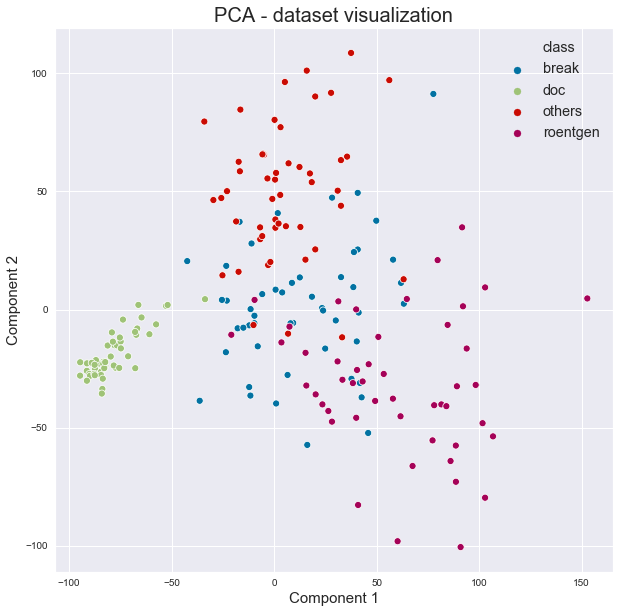

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plot = sns.scatterplot(df_pca.pc1,df_pca.pc2,df_pca["class"],s=50)
plot.axes.set_title('PCA - dataset visualization',fontsize=20)
plot.set_xlabel("Component 1",fontsize=15)
plot.set_ylabel("Component 2",fontsize=15)
plot.legend(fontsize='x-large', title_fontsize='20')
plt.show()

It's clearly visible on above plot that classes are distinguishable (especially medical documents and others images). However, X-Rays and images of injuries penetrate significantly each other. Additionally prediagnostics will be considered to receive more informations about clusters.

#### Hopkins statistic and visual assessment of cluster tendency

Calculation of Hopkins statistic is highly ineffective on big dataset, so two sampling sizes will be provided to obtain robustness of this analysis. 

In [127]:
clust_tendency = scale(df.iloc[:,:-1])
print("Hopkins statistic",hopkins(clust_tendency,25)) ## Hopkins statistic with 25 sampling size

Hopkins statistic 0.2046101436925963


In [128]:
clust_tendency = scale(df.iloc[:,:-1])
print("Hopkins statistic",hopkins(clust_tendency,50)) ## Hopkins statistic with 50 sampling size

Hopkins statistic 0.2199592198129442


Hopkins statistic in both attempts returns: ~ 0.20. It's closer to 0 than 0.5, thus the null hypothesis should be accepted: "the dataset is uniformly distributed" (unlikely that there are statistically significant clusters).

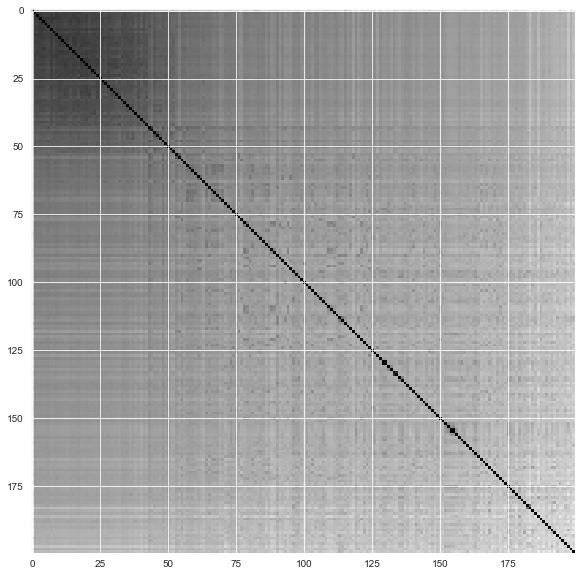

In [126]:
vat(df.iloc[:,:-1],) #visual assessment of cluster tendecy plot

Visual Assessment of Cluster Tendecy suggests that dataset is hard to segmentation. Plot is dominated by light gray which represents high dissimilarity in data (low similarity), only small part can be characterized as high similarity points - potentially belong to one cluster.  

#### K-Means 

First, clustering was performed using the K-Means algorithm. To determine the number of clusters that give the best result for this algorithm scientists used:
* Distortion Score Elbow -  computes the sum of squared distances from each point to its assigned center,
* Silhouette Score Elbow - computes the mean Silhouette Coefficient of all samples,
* Calinski - Harabasz Score Elbow - computes the ratio of dispersion between and within clusters.
<br><br>
This is not a flawless approach because the data is not very clustered, but it needs investigation on real data.

Basing on <b>Distortion Score Elbow</b> is very hard to decide which k will be the best one. Scientists guess that it might be k equal to 3 or 4.

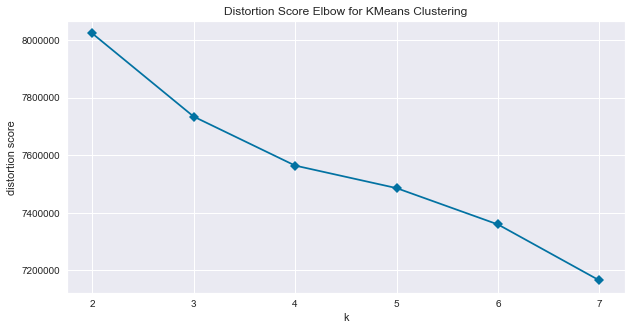

In [168]:
model = KMeans(random_state=2018)#defining kmeans model
plt.rcParams['figure.figsize'] = [10, 5]
visualizer = KElbowVisualizer(model, k=(2,8),metric='distortion',timings=False,locate_elbow=False) #creating ploting model of elbow based on metric assuption
visualizer.fit(df.iloc[:,:-1]) #fitting visualizer model
sns.set_style("darkgrid")
visualizer.show()

<b>Silhoutette Score Elbow</b> suggests that k must be equal to 5, because Silhoutette Score for this cluster is the highest.

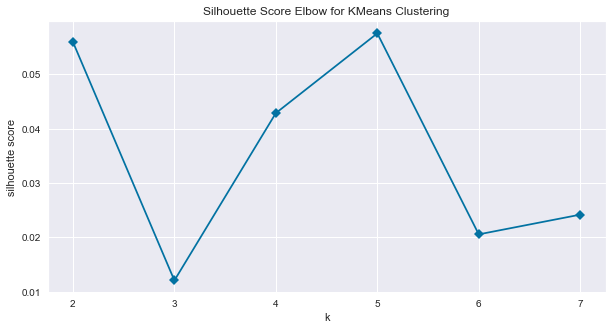

In [169]:
model = KMeans(random_state=2018)#defining kmeans model
plt.rcParams['figure.figsize'] = [10, 5]
visualizer = KElbowVisualizer(model, k=(2,8),metric='silhouette',timings=False,locate_elbow=False) #creating ploting model of elbow based on metric assuption
visualizer.fit(df.iloc[:,:-1]) #fitting visualizer model
sns.set_style("darkgrid")
visualizer.show()

On the other hand <b>Calinski Harabasz</b> metric shows that 2 clusters will be the proper number for Kmeans.

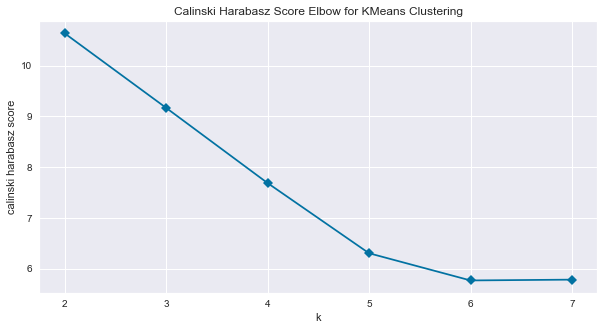

In [170]:
model = KMeans(random_state=2018)#defining kmeans model
plt.rcParams['figure.figsize'] = [10, 5]
visualizer = KElbowVisualizer(model, k=(2,8),metric='calinski_harabasz',timings=False,locate_elbow=False) #creating ploting model of elbow based on metric assuption
visualizer.fit(df.iloc[:,:-1]) #fitting visualizer model
sns.set_style("darkgrid")
visualizer.show()

As assumed, the above approaches do not work very well and return wrong information altogether. Therefore, the authors tried to use GAP statistics for this exercise. However, it turned out that none of the available Python packages can calculate this statistic due to numerical problems caused by the input matrix. <br><br>Ultimately, the authors decided to base their next steps mainly on the Silhoutette Score Elbow plot, because it seems the most reliable, relative to apriori's knowledge of the data set.<br><br>
All in all researchers will check KMeans clustering using k = {2, 3, 5}. <br><br> The analysis of clustering results boils down to: visualization of clusters using PCA (with distinction of photo class) and the SIlhouette chart.

In [48]:
#function dedicated to visualization of clusters using PCA (with distinction of photo class) and the SIlhouette chart ploting.
def clustering_plot(model_,title): 
    pca = PCA(n_components=2) # pca object
    principalComponents = pca.fit_transform(df.iloc[:,:-1]) #fitting dataframe to PCA
    df_pca = pd.DataFrame(principalComponents,columns=["pc1","pc2"])
    df_pca["class"] = df["class"].values

    labels = model_.fit_predict(df.iloc[:,:-1]) #obtaining labels from model which was passed to the function
    df_pca["cluster"] = labels #assignment of labels to nice pca dataframe
    
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    sns.set_style("darkgrid")
    plt.figure(figsize=(10,10))
    plot = sns.scatterplot(df_pca.pc1,df_pca.pc2,df_pca["cluster"],s=50,style=df_pca["class"], palette="Set2",legend='full') #ploting results taking into account class of the image distinction
    plot.axes.set_title(f'{title}',fontsize=20)
    plot.set_xlabel("Component 1",fontsize=15)
    plot.set_ylabel("Component 2",fontsize=15)
    plot.legend(fontsize='x-large', title_fontsize='20')
    plt.show()

In [52]:
kmeans1 = KMeans(n_clusters=2, random_state=2019)

K-Means with k = 2 seems to be inappropriate in this specific case due to lack of extraction medical documents data. Actually data are splitted in a half, which is not useful.

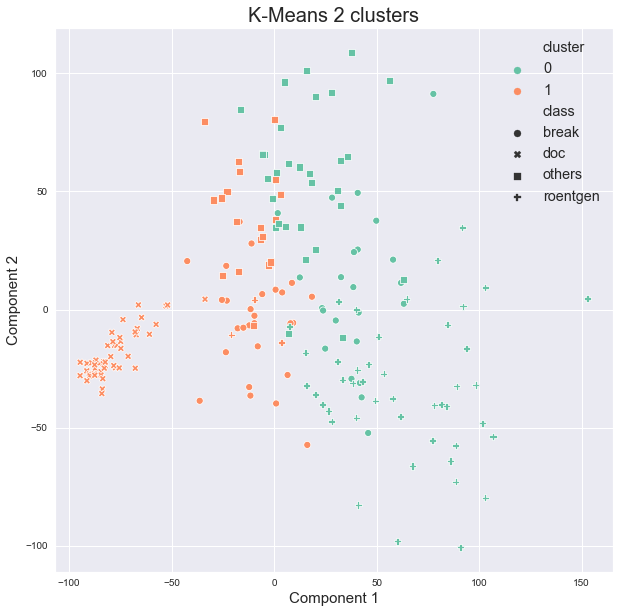

In [53]:
clustering_plot(kmeans1,"K-Means 2 clusters")

Silhouette chart suggests that clusters size is similar, while cluster 0 is mediocre.

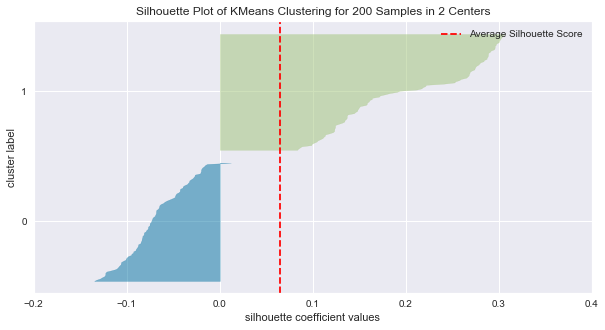

In [54]:
plt.rcParams['figure.figsize'] = [10, 5]
visualizer = SilhouetteVisualizer(kmeans1, colors='yellowbrick')
visualizer.fit(df.iloc[:,:-1])
visualizer.show()

In [55]:
kmeans2 = KMeans(n_clusters=3, random_state=2019)

K-Means with k = 3 looks better than the previous model but still it's far from ideal one.

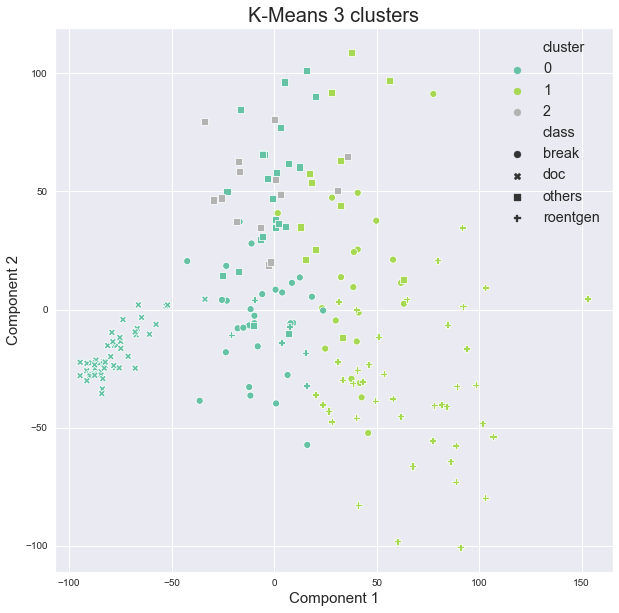

In [56]:
clustering_plot(kmeans2,"K-Means 3 clusters")

The chart below also confirms this understanding of the results. The most interesting for scientists was separation in the zero class. However, this one did not go well.

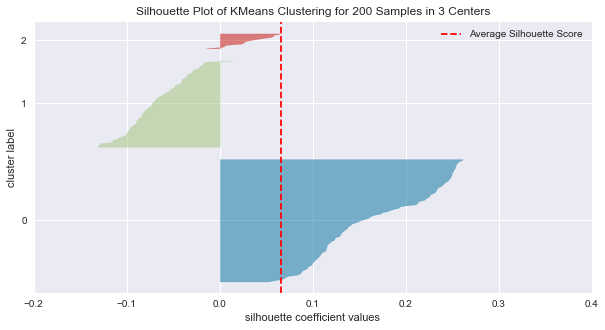

<Figure size 720x720 with 0 Axes>

In [57]:
visualizer = SilhouetteVisualizer(kmeans2, colors='yellowbrick')
visualizer.fit(df.iloc[:,:-1])
plt.figure(figsize=(10,10))
visualizer.show()

In [54]:
kmeans3 = KMeans(n_clusters=5, random_state=2019)

K-Means with 5 clusters is suggested by Silhouette Elbow plot. Based on the visualization below, it can be said that this is indeed the most effective approach taking into account goal of this study.

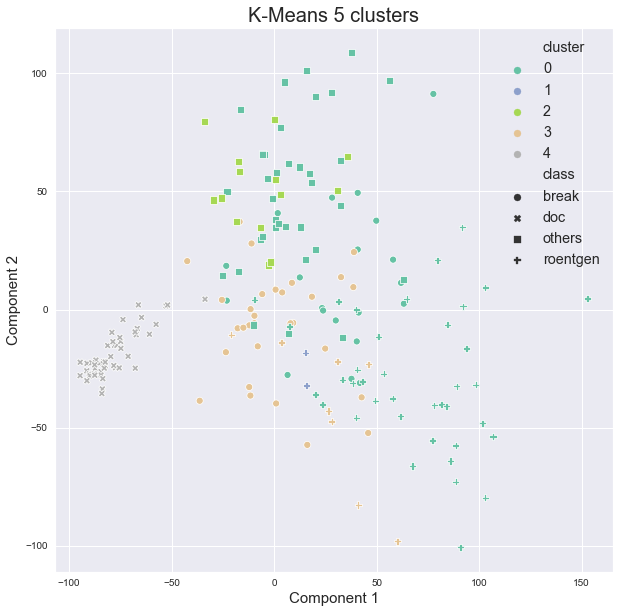

In [55]:
clustering_plot(kmeans3,"K-Means 5 clusters")

Indeed, the class that most scientists care about ("medical documents" / "doc") is best separated and has a very high Silhouette score. Others look a lot worse, but that doesn't bother scientists.

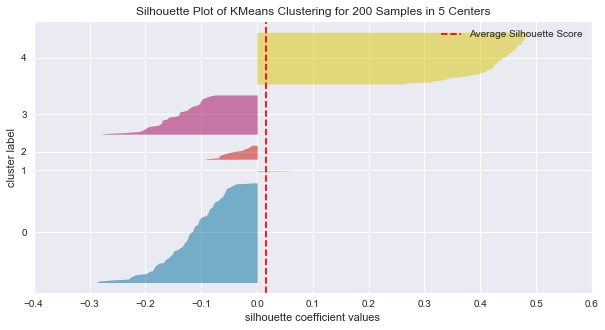

In [65]:
visualizer = SilhouetteVisualizer(kmeans3, colors='yellowbrick')
visualizer.fit(df.iloc[:,:-1])
visualizer.show()

In [49]:
kmeans4 = KMeans(n_clusters=4, random_state=2019)

It also seems reasonable to check the K-Means 4, because 4 classes of photos were introduced at the entrance of the study.

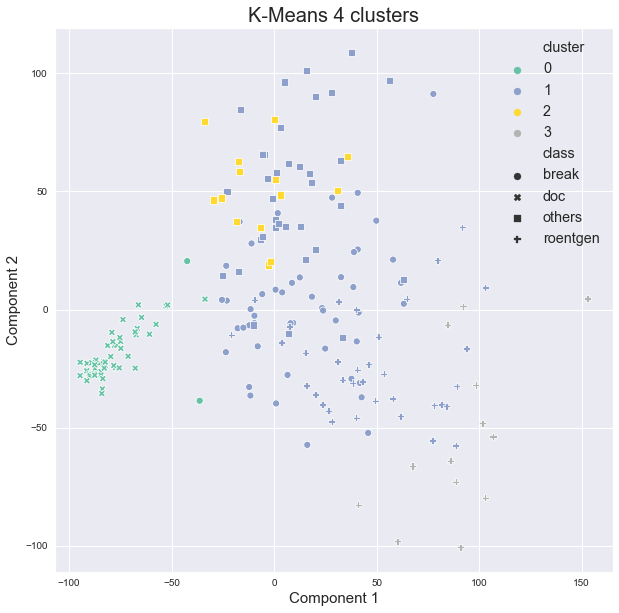

In [50]:
clustering_plot(kmeans4,"K-Means 4 clusters")

The results look similar to k = 5.

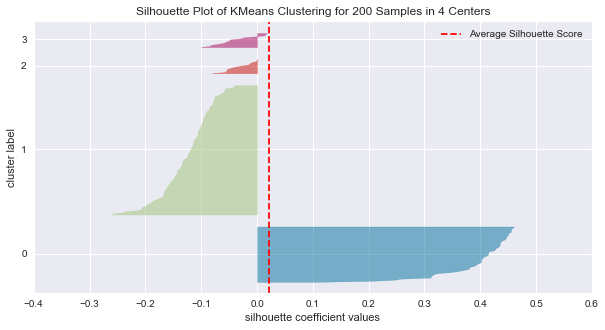

In [52]:
visualizer = SilhouetteVisualizer(kmeans4, colors='yellowbrick')
visualizer.fit(df.iloc[:,:-1])
visualizer.show()

Researchers applied Adjusted Rand Score to confirm the above thesis about the similarity of clusters for k = 4 and k = 5. As it turned out statistically, they are not similar to each other in a satisfactory way (result at the level of about 50 percent).

In [56]:
adjusted_rand_score(kmeans3.fit_predict(df.iloc[:,:-1]),kmeans4.fit_predict(df.iloc[:,:-1]))

0.5410673768025202

Ultimately, scientists decided that the best model is the one with k = 5. They decided to calculate 𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 for it. To this end, they manually calculated: FN ratio and FP ratio. Calculations posted below.

In [57]:
df_kmeans_final = df.copy()
labels = kmeans3.fit_predict(df.iloc[:,:-1])
df_kmeans_final["cluster"] = labels

In [58]:
df_kmeans_final[df_kmeans_final["class"]=="doc"]["cluster"].value_counts() #obtaining FN ratio

4    50
Name: cluster, dtype: int64

In [59]:
df_kmeans_final[df_kmeans_final["cluster"]==4]["class"].value_counts() #obtaining FP ratio

doc    50
Name: class, dtype: int64

In [93]:
𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 = 1
Recall = 1 
𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐=0.3 * Precision + 0.7 * Recall
print("𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 = ",𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐)

𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 =  1.0


𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 is 1 and is ideal. However, it should be remembered that this required thorough investing of clusters, which is a serious weakness of the algorithm. The most intuitive seems to be the use of k = 4. This will return poorer results, but in the conditions of commercial projects will be the most obvious choice. To sum up in the case of the K-Means algorithm, it is better to decide to the number of clusters corresponding to the number of classes attached into the input set, than the number of 2 clusters, in order to make a binary classification.

#### DBSCAN

For the DBSCAN algorithm, the most effective way to obtain the necessary hyperparameter: epsilon is to use the k-distance graph. The researchers assumed that the number of Nearest Neighbors would be set to 3. Based on the graph below, it is difficult to clearly determine where the knee occurs. Therefore, it was decided to test epsilon equal to {120, 150, 175, 200}. What is important the euclidean metric was used in all DBSCAN studies.

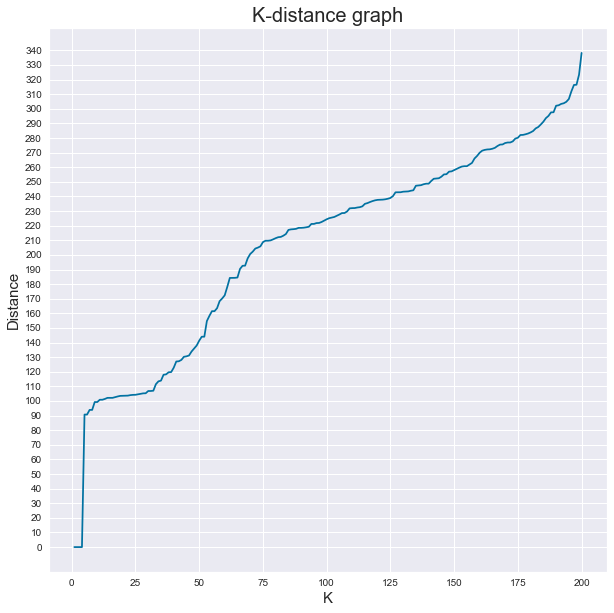

In [60]:
neigh = NearestNeighbors(n_neighbors=3,metric="euclidean")
nbrs = neigh.fit(df.iloc[:,:-1])
distances, indices = nbrs.kneighbors(df.iloc[:,:-1])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plot = sns.lineplot(np.arange(1,201,1),distances)
plot.axes.set_title("K-distance graph",fontsize=20)
plot.set_xlabel("K",fontsize=15)
plot.set_ylabel("Distance",fontsize=15)
plot.set_yticks(np.arange(0,350,10)) 
plt.show()

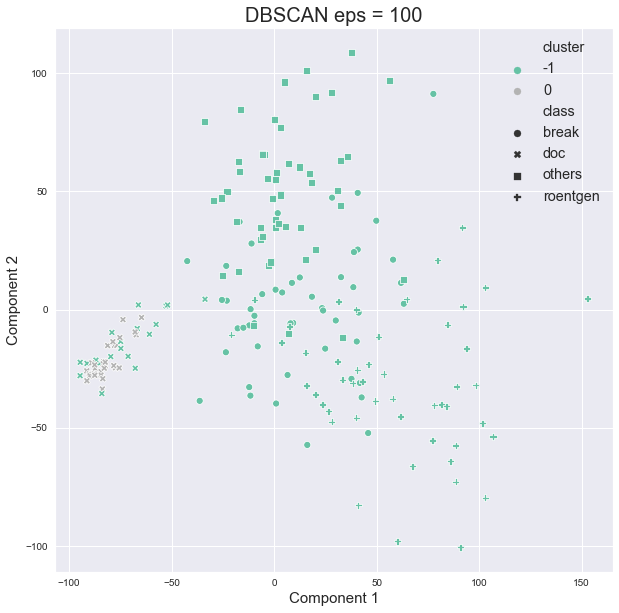

Silhouette Coefficient: -0.07243376604332807


In [151]:
dbscan1 = DBSCAN(eps=120, min_samples=3)
clustering_plot(dbscan1,"DBSCAN eps = 100")
sil = silhouette_score(df.iloc[:,:-1], dbscan1.fit_predict(df.iloc[:,:-1]), metric='euclidean')
print("Silhouette Coefficient:",sil)

One above plot many False Negatives are visible. It's poor result.

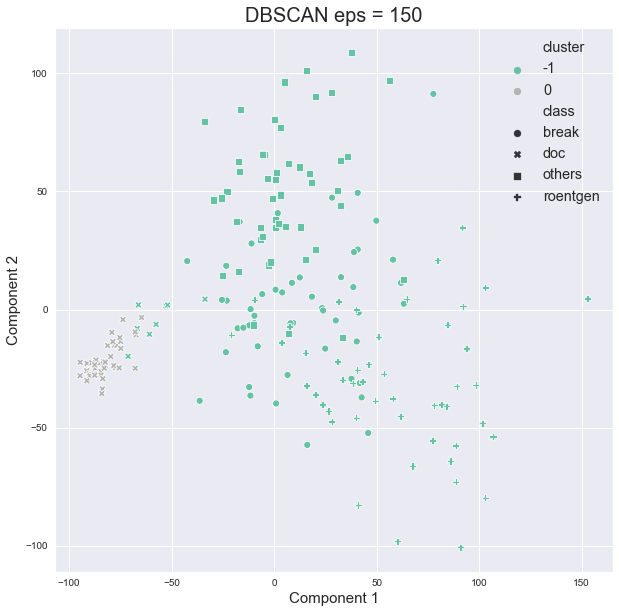

Silhouette Coefficient: -0.023579590509684653


In [152]:
dbscan2 = DBSCAN(eps=150, min_samples=3)
clustering_plot(dbscan2,"DBSCAN eps = 150")
sil = silhouette_score(df.iloc[:,:-1], dbscan2.fit_predict(df.iloc[:,:-1]), metric='euclidean')
print("Silhouette Coefficient:",sil)

Here less False Negatives are visible than in previous one graph but still it is not satisfying result.

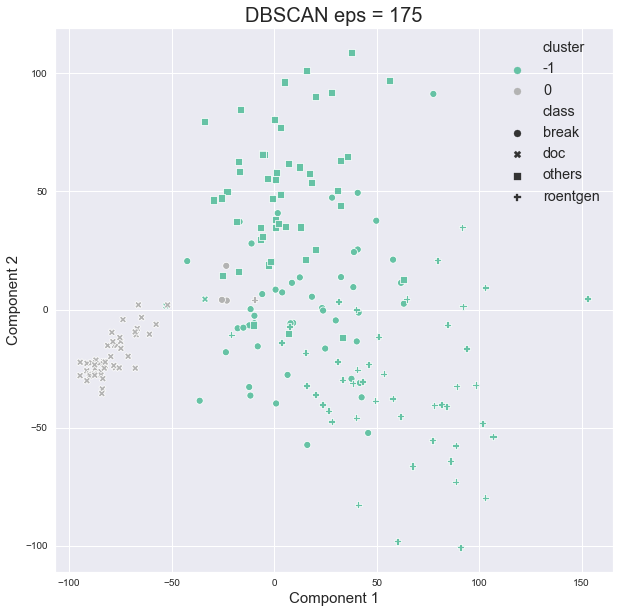

Silhouette Coefficient: 0.0023234056293876025


In [153]:
dbscan3 = DBSCAN(eps=175, min_samples=3)
clustering_plot(dbscan3,"DBSCAN eps = 175")
sil = silhouette_score(df.iloc[:,:-1], dbscan3.fit_predict(df.iloc[:,:-1]), metric='euclidean')
print("Silhouette Coefficient:",sil)

DBSCAN with epsilon equal to 175 in this case characterized by relatively low ratio of False Positives.

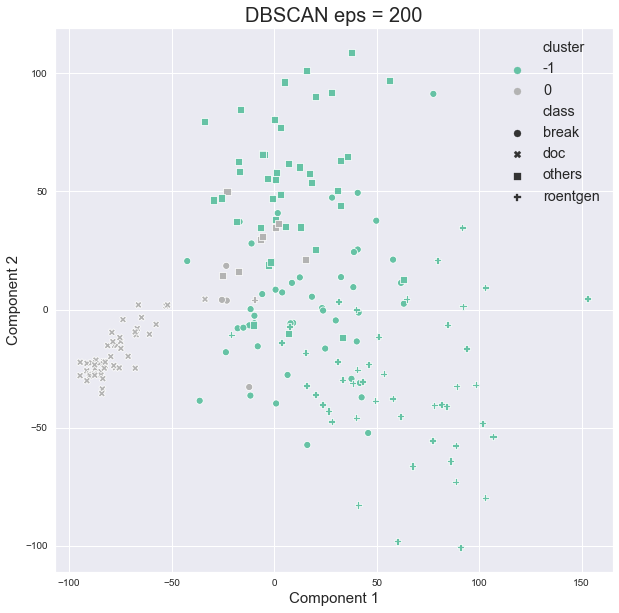

Silhouette Coefficient: 0.020714128292251468


In [154]:
dbscan4 = DBSCAN(eps=200, min_samples=3)
clustering_plot(dbscan4,"DBSCAN eps = 200")
sil = silhouette_score(df.iloc[:,:-1], dbscan4.fit_predict(df.iloc[:,:-1]), metric='euclidean')
print("Silhouette Coefficient:",sil)

DBSCAN with epsilon equal to 200 has slightly more False Positives than previous model.

After analyzing the above 4 results for the DBSCAN algorithm, it was found that no approach is satisfactory. It was very hard to hit with the right epsilon hyperparameter. What is more it does not seem reasonable to use the Average Silhouette Coefficient to determine the best model, because due to the specifics of the study, the larger the epsilon, the larger the metric. Which in practice means noise. Ultimately, it was decided to choose models 3 and 4 to further analysis.

Adjusted Rand Score for DBSCAN model 3 and DBSCAN model 4 is around 0.785 which is high.

In [155]:
adjusted_rand_score(dbscan3.fit_predict(df.iloc[:,:-1]),dbscan4.fit_predict(df.iloc[:,:-1]))

0.7845864489479553

The selection of the best model in this case is based on the analysis of the above chart. This is quite an arbitrary task. Finally, model 3 was selected as the best one.

In [166]:
df_dbscan_final = df.copy()
labels = dbscan3.fit_predict(df.iloc[:,:-1])
df_dbscan_final["cluster"] = labels

In [165]:
df_dbscan_final[df_dbscan_final["class"]=="doc"]["cluster"].value_counts() #obtaining FN ratio

 0    48
-1     2
Name: cluster, dtype: int64

In [160]:
df_dbscan_final.iloc[:,-2:][df_dbscan_final["cluster"]==0]["class"].value_counts() #obtaining FP ratio

doc         48
break        3
roentgen     1
Name: class, dtype: int64

In [167]:
𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 = 48 / (48 + 4)
Recall = 48 / (48 + 2)
𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐=0.3 * Precision + 0.7 * Recall
print("𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 = ",𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐)

𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 =  0.9489230769230769


𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 is equal to 0.95 and it is good enought to pass task conditions. As emphasized earlier using DBSCAN for this problem, it is very problematic to determine the right epsilon. Epsilon taken from the appropriate range should guarantee a fairly constant variance in the results obtained. However, it may turn out that obtaining such a range is costly in time, because it requires some knowledge about the distribution of photo classes in the analyzed sample.

#### Birch

Birch algorithm requires 3 hyperparameters. Two of them in this case will be set to deafult values: branching_factor = 50, threshold=0.5. The most important for researchers here is number of clusters parameter. There is no proper approach to find best number of clusters for Birch, so values like: 2, 3, 4 will be tested. Of course 4 cluters are the most obvious one (4 classes of pictures).

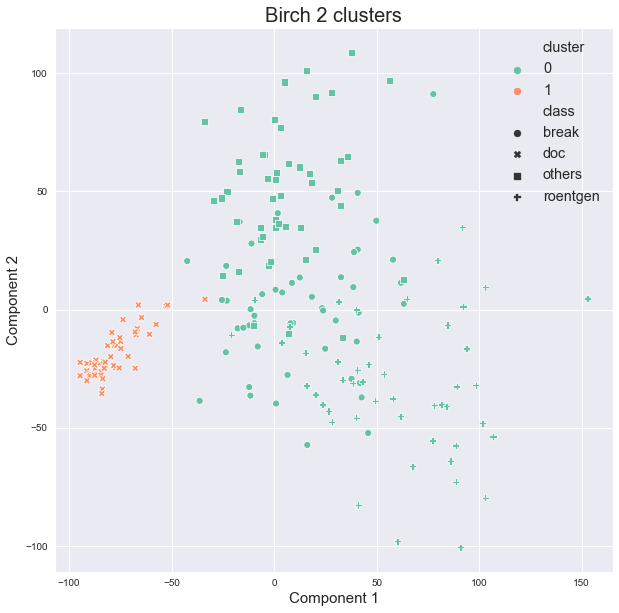

Silhouette Coefficient: 0.0016818505848160824


In [64]:
birch1 = Birch(n_clusters=2, branching_factor = 50, threshold=0.5)
clustering_plot(birch1,"Birch 2 clusters")
sil = silhouette_score(df.iloc[:,:-1], birch1.fit_predict(df.iloc[:,:-1]), metric='euclidean')
print("Silhouette Coefficient:",sil)

Birch with 2 clusters did real impact. It has clustered dataset in expected way, what scientists mean: medical documents are separated from the rest of pictures.

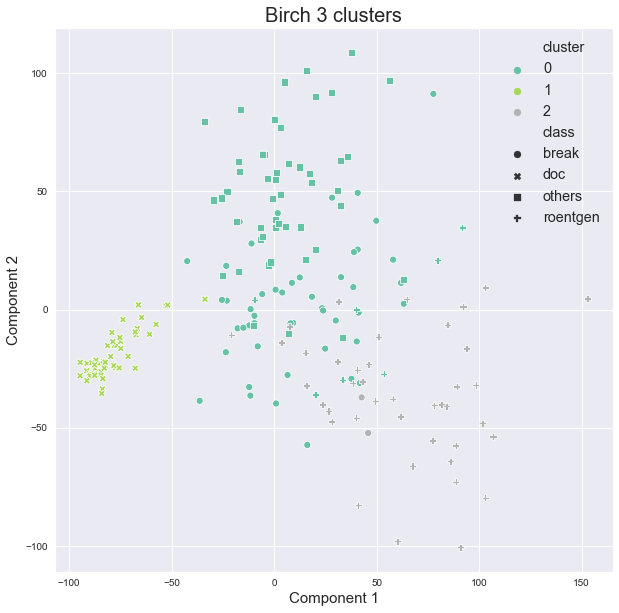

Silhouette Coefficient: 0.008269964189299489


In [65]:
birch2 = Birch(n_clusters=3,  branching_factor = 50, threshold=0.5)
clustering_plot(birch2,"Birch 3 clusters")
sil = silhouette_score(df.iloc[:,:-1], birch2.fit_predict(df.iloc[:,:-1]), metric='euclidean')
print("Silhouette Coefficient:",sil)

Application of Birch with 3 clusters has no sense as results show. It is not intuitive and it does not introduce any positive impact on clustering.

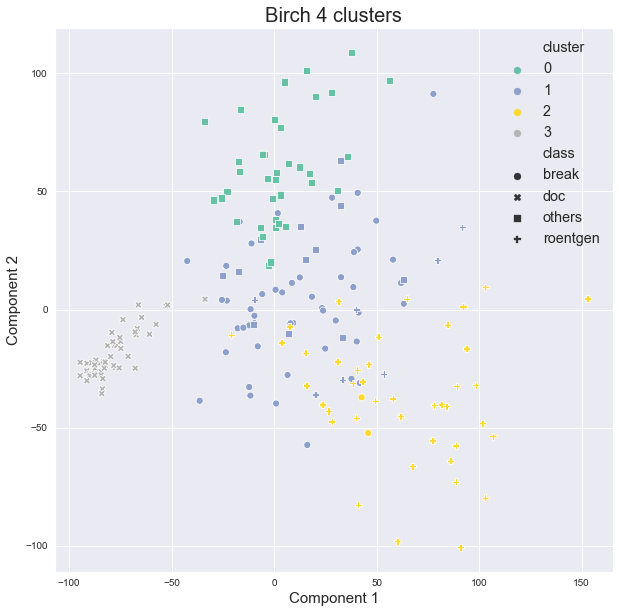

Silhouette Coefficient: 0.01314028264594489


In [66]:
birch4 = Birch(n_clusters=4,  branching_factor = 50, threshold=0.5)
clustering_plot(birch4,"Birch 4 clusters")
sil = silhouette_score(df.iloc[:,:-1], birch4.fit_predict(df.iloc[:,:-1]), metric='euclidean')
print("Silhouette Coefficient:",sil)

Birch with 4 clusters seems to be very efficient in this case. Classes of images are well clustered (basing on above plot). <br><br>Analysis of Adjusted Rand Score in this case will be not necessary.<br><br>Finally model with 4 clusters has been choosen, because it is the most intuitive number of splits. For this model 𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 was calculated.

In [70]:
df_birch_final = df.copy()
labels = birch4.fit_predict(df.iloc[:,:-1])
df_birch_final["cluster"] = labels

In [71]:
df_birch_final[df_birch_final["class"]=="doc"]["cluster"].value_counts() #obtaining FN ratio

3    50
Name: cluster, dtype: int64

In [73]:
df_birch_final[df_birch_final["cluster"]==3]["class"].value_counts() #obtaining FP ratio

doc    50
Name: class, dtype: int64

In [198]:
𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 = 1
Recall = 1 
𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐=0.3 * Precision + 0.7 * Recall
print("𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 = ",𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐)

𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 =  1.0


Of course 𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐 is equal to 1. As it occurred, Birch model works close to perfect in such environment (CF-tree seems to be efficient for such features). By choosing Birch with 4 clusters it was possible to obtain very good outcomes for every class in multi-class classification task. In this specific research binary classification also works good enought for Birch with 2 clusters. It provides very elastic approach.

# Conclusions

### Comparison of results obtained by: KMeans, DBSCAN, Birch

Taking into account all three models, the most robust and efficient (based on: 𝑄𝑢𝑎𝑙𝑖𝑡𝑦𝑀𝑒𝑡𝑟𝑖𝑐, plots and time required to obtain the best possible clustering) is Birch. It completly outperformed others. K-Means works good also but it requires long calibration time (looking for number of clusters) - it is highly inappropriate during commercial projects. Calibration procedure in this case means: preparation of supervised sample (with known labels) and finding specific number of clusters (which might be generalized for whole dataset). DBSCAN completely does not work for this problem - it returns unsatisfactory results compared to the rest. Searching possible epsilon space is highly inefficient. It is wise to choose the BIRCH model based on this research.

### Proposed algorithm

After whole analysis authors proposed following algorithm:
1. Loading and preprocessing dataset (resizing, dimension expanding, subtracting the mean RGB channels of the ImageNet dataset and etc.)
2. Loading and applying pre-trained Inception ResNet V2 on data from 1 point to obtain features for each image.
3. Applying Birch model on obtained features from 2 point. It is required to specify number of clusters based on user needs (binary classification: number of clusters is equal to 2, k-class classification: number of clusters is equal to k).
4. Saving outputs to directory with respect to clusters.

### Scientific hypothesis
It is possible to construct fast, precise and robust semi-automatic algorithm for image clustering using pre-trained convolutional neural networks and unsupervised machine learning clustering algorithms, especially using proposed algorithm.

### Business hypothesis
New approach presented in this research can obtain Quality Metric in range [0.9, 1.0].

## References

1) K. Wagstaff, S. Rogers, "Constrained K-means Clustering with Background Knowledge", Department of Computer Science, Cornell University, Ithaca, NY, USA;  DaimlerChrysler Research and Technology Center, USA, (https://web.cse.msu.edu/~cse802/notes/ConstrainedKmeans.pdf), 2001. <br><br>
2) D. Birant, A. Kut, "ST-DBSCAN: An algorithm for clustering spatial–temporal data", Data & Knowledge Engineering, Elsevier, (https://www.sciencedirect.com/science/article/pii/S0169023X06000218#!), 2007. <br><br>
3) T. Zhang, R. Ramakrishnan, M. Livny, "BIRCH: An Efficient Data Clustering Method for Very Large Databases", Compputer Sciences Dept. Univ. of Wisconsin-Madison, (https://www2.cs.sfu.ca/CourseCentral/459/han/papers/zhang96.pdf), 1996. <br><br>
4) S. Bianco, R. Cadene, L. Celona, P. Napoletano, "Benchmark Analysis of Representative Deep Neural Network Architectures", University of Milano-Bicocca, Milano, Italy; Sorbonne Université, Paris, France, (https://arxiv.org/pdf/1810.00736.pdf) 2018. <br><br>
5) C. Szegedy, S. Ioffe, V. Vanhoucke, A. Alemi, "Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning", Google Inc. 1600 Amphitheatre Pkwy, Mountain View, CA, (https://arxiv.org/pdf/1602.07261.pdf), 2016. <br><br>
6) A. Alemi, "Improving Inception and Image Classification in TensorFlow", Google AI Blog, (https://ai.googleblog.com/2016/08/improving-inception-and-image.html), 2016.